In [1]:
import pandas as pds
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
    

In [2]:
# load csv files into dataframes
# the paramaters low_memory=False, dtype=str tell pandas not to guess the datatype
# and make everything a string
# note: many posts say low_memory=False doesn't do anything ... 
df_patients = pds.read_csv('patients.csv', low_memory=False, dtype=str, encoding='utf-8')
df_patients_teeth = pds.read_csv('patient_teeth.csv', low_memory=False, dtype=str, encoding='utf-8')
df_tooth_caries = pds.read_csv('tooth_caries.csv', low_memory=False, dtype=str, encoding='utf-8')
df_tooth_surface_caries = pds.read_csv('tooth_surface_caries.csv', low_memory=False, dtype=str, encoding='utf-8')
df_tooth_procedures = pds.read_csv('tooth_procedures_no_es.csv', low_memory=False, dtype=str, encoding='utf-8')
df_tooth_surface_procedures = pds.read_csv('tooth_surface_procedures_no_es.csv', low_memory=False, dtype=str, encoding='utf-8')

In [3]:
# drop duplicates from dataframes
df_patients.drop_duplicates(inplace=True)
df_patients_teeth.drop_duplicates(inplace=True)
df_tooth_caries.drop_duplicates(inplace=True)
df_tooth_surface_caries.drop_duplicates(inplace=True)
df_tooth_procedures.drop_duplicates(inplace=True)
df_tooth_surface_procedures.drop_duplicates(inplace=True)

In [4]:
# testing output
# df_patients.head() # good
# df_patients_teeth.head() # good
# df_tooth_caries.head() # good
# df_tooth_surface_caries.head() # good
# df_tooth_procedures.head() # good
# df_tooth_surface_procedures.head() # good

In [5]:
# len(df_patients) # 229,414

In [6]:
# len(df_patients_teeth) # 1,231,726

In [7]:
# print number of patients
# alternative method: df_patients.count() # 229,414
# len(df_patients) # simplier -> 229,414

# get counts of genders
group = df_patients.gender.value_counts()

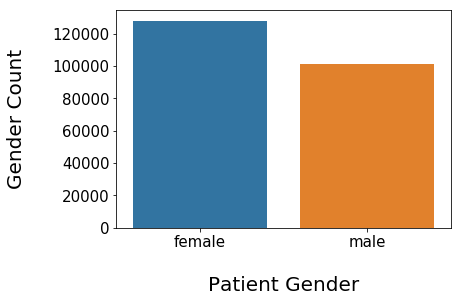

In [8]:
# plot gender counts
# ax = sns.countplot(x="gender", data=group)
ax = sns.barplot(x=group.index, y=group.values)
ax.set_xlabel("\nPatient Gender", size=20)
ax.set_ylabel("Gender Count\n", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [9]:
# merge, patients, teeth data frames
df_teeth = pds.merge(df_patients, df_patients_teeth, \
                             how='inner', on=['patient_id'])
df_teeth.drop_duplicates(inplace=True)
# df_teeth.head()

In [10]:
# len(df_teeth) # left join -> 1,238,655; inner join -> 1,227,812; right join -> 1,227,812
# len(df_patients_teeth) # 1,227,812

In [11]:
# merge teeth and procedures data frames
temp = df_tooth_procedures[df_tooth_procedures.tooth_id.isin(df_teeth.tooth_id)]
# len(df_tooth_procedures) # 1,681,694
# len(temp) # 1,675,416

df_procedures = pds.merge(df_teeth, temp, how='left', on=['tooth_id', 'tooth_num'])
# len(df_procedures) # 1,682,057
# df_procedures.head()

In [12]:
# merge procedures with surface information
# this final dataset will be the 'observations' dataset
temp = df_tooth_surface_procedures[df_tooth_surface_procedures.event_id.isin(df_procedures.event_id)]
# len(df_tooth_surface_procedures) # 1,245,022
# len(temp) # 1,241,352

df_obs = pds.merge(df_procedures, temp, how='left', on=['event_id', 'tooth_id', 'tooth_num'])
len(df_obs) # 1,682,057; this matches df_procedures count above ... good

1696526

In [13]:
df_extracted = df_obs[df_obs.extract_date.notnull()][['tooth_id','tooth_num']]
# df_extracted = df_obs[df_obs.extract_date.notna()][['tooth_id','tooth_num']]
df_extracted.tooth_num = pds.to_numeric(df_extracted.tooth_num)
df_extracted.drop_duplicates(inplace=True)
df_extracted.head()
df_extracted.groupby('tooth_num').count()
# len(df_extracted) # isnull -> 1,617,783; isna -> 1,617,783; notnull -> 41,331; notna -> 41,331

,tooth_id
tooth_num,
1,953
2,2098
3,1831
4,1373
5,1226
6,624
7,842
8,740
9,772


In [14]:
temp1 = df_obs[['tooth_num', 'tooth_id', 'extract_date']] #.fillna(0)
len(temp1)
# temp2 = temp1[temp1.extract_date == 0]
# temp2 = temp1.query("extract_date != extract_date")
temp2 = temp1[temp1.extract_date.notnull()]
# temp2.drop_duplicates(inplace=True)
temp3 = temp2[['tooth_num', 'tooth_id']]
print(len(temp3))
# temp3.groupby('tooth_num').size()
temp3.drop_duplicates(inplace=True)
temp3.tooth_num.value_counts()
# print(len(temp3))
# temp2.head()
# temp3.groupby('tooth_num').size()
# temp2.tooth_num.value_counts()
# temp3 = temp2.query("tooth_num == '1'")
# temp3.drop_duplicates(inplace=True)
# print(len(temp3))

89804


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


15    2275
31    2186
2     2098
18    2055
30    1968
19    1941
3     1831
14    1819
4     1373
13    1354
12    1226
5     1226
29    1051
20    1022
16     962
1      953
17     898
32     875
7      842
10     817
9      772
8      740
6      624
11     603
28     598
21     551
25     368
24     336
23     321
26     316
27     240
22     236
Name: tooth_num, dtype: int64

In [15]:
temp4 = temp3.query("tooth_num == '1'")
temp4.head()

,tooth_num,tooth_id
275,1,A_1_1_1_1
1084,1,A_1_1_149_1
8836,1,A_1_1_2946_1
13571,1,A_1_1_3302_1
15481,1,A_1_1_3046_1


In [16]:
# print column names for easy reference
print(df_obs.columns)

Index(['practice', 'patient_id', 'gender', 'dob', 'first_visit', 'last_visit',
       'tooth_id', 'tooth_num', 'first_PCR', 'first_RCT', 'extract_date',
       'missing_date', 'event_id', 'event_name', 'event_date', 'ada_code', 'm',
       'o', 'd', 'b', 'l', 'f', 'i'],
      dtype='object')


In [17]:
# convert columns to datetime datatype (in case they aren't stored as datetimes)
df_obs.dob = pds.to_datetime(df_obs.dob)
df_obs.first_visit = pds.to_datetime(df_obs.first_visit, errors = 'coerce')
df_obs.last_visit = pds.to_datetime(df_obs.last_visit, errors = 'coerce')
df_obs.first_PCR = pds.to_datetime(df_obs.first_PCR, errors = 'coerce')
df_obs.first_RCT = pds.to_datetime(df_obs.first_RCT, errors = 'coerce')
df_obs.event_date = pds.to_datetime(df_obs.event_date, errors = 'coerce')
df_obs.extract_date = pds.to_datetime(df_obs.extract_date, errors = 'coerce')
df_obs.missing_date = pds.to_datetime(df_obs.missing_date, errors = 'coerce')

# df_obs.head()

In [18]:
# add patient ages to observations (using year 2017)
df_obs['patient_age'] = 2017 - pds.to_datetime(df_obs.dob).dt.year

# df_obs[['dob', 'patient_age']].head()

In [19]:
# some of the patient ages are less than zero due to bad DOB data
# let's drop the records
df_obs = pds.DataFrame(df_obs.query('patient_age > 0'))

# df_obs[['dob', 'patient_age']].head()
# df_obs.head()

In [20]:
# df_teeth.tooth_num.count()
# df_teeth.groupby('tooth_num').count()

# temp = df_teeth[~np.isnat(df_teeth.extract_date)]
# temp = df_teeth[~df_teeth.extract_date.isnull()]
# temp = temp.query("tooth_num == '7'")
# temp.groupby('tooth_num').count()
# temp.head()

In [21]:
# create dataframe of patient demographics
# note the use of drop_duplicates so that we have distict patients
df_demographics = df_obs[['practice', 'patient_id', 'gender', 'dob', 'patient_age']].drop_duplicates()

# df_demographics.head()

In [22]:
# create separate dataframes for genders
# there is probably a better way to do this ...
df_females = df_demographics.query("gender == 'female'")[['gender', 'patient_age']]
df_males = df_demographics.query("gender == 'male'")[['gender', 'patient_age']]

# testing output
# df_females.head()
# print(len(df_females))
# df_females.groupby('patient_age').count()

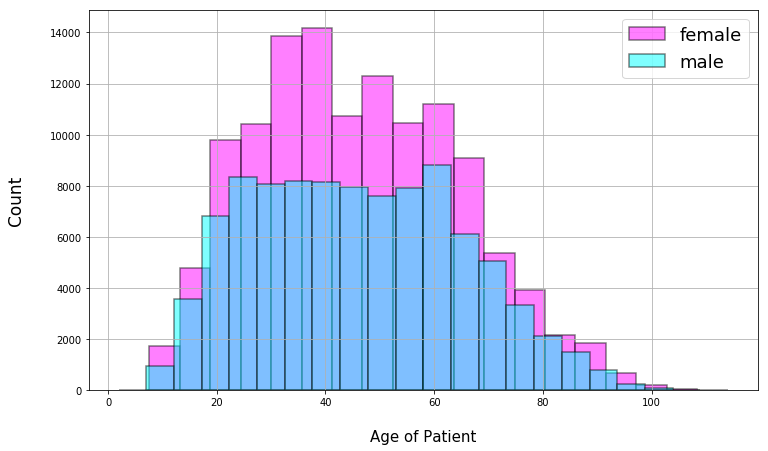

In [23]:
# plot age/gender distribution
ax = df_females["patient_age"]\
        .hist(bins=20, alpha=0.5, color='magenta', label='female', edgecolor='black', linewidth=1.5,figsize=(12,7))
ax = df_males["patient_age"]\
        .hist(bins=20, alpha=0.5, color='cyan', label='male', edgecolor='black', linewidth=1.5, figsize=(12,7))

ax.set_xlabel("\nAge of Patient", fontsize=15)
ax.set_ylabel("Count\n", fontsize=17)

plt.legend(loc='upper right', prop={'size': 18})
plt.show()

In [33]:
# build dataframe of restorations on surfaces
df_fillings = df_obs[['tooth_id', 'tooth_num', 'ada_code', 'event_name', 'm','o', 'd', 'b', 'l', 'f', 'i']]
# df_fillings = df_fillings.query(""" \
#                     ada_code.str.startswith('D') \
#                     and event_name.str.contains('filling') \
#                     and (m==1 or o==1 or d==1 or b==1 or l==1 or f==1 or i==1)"""
#                     , engine="python") # engine="python" is needed for str functions to work
# df_fillings = df_fillings.query(""" m==1 or o==1 or d==1 or b==1 or l==1 or f==1 or i==1"""
#                                     , engine="python") # engine="python" is needed for str functions to work
df_fillings.m = pds.to_numeric(df_fillings.m)
df_fillings.o = pds.to_numeric(df_fillings.o)
df_fillings.d = pds.to_numeric(df_fillings.d)
df_fillings.b = pds.to_numeric(df_fillings.b)
df_fillings.l = pds.to_numeric(df_fillings.l)
df_fillings.f = pds.to_numeric(df_fillings.f)
df_fillings.i = pds.to_numeric(df_fillings.i)
# df_fillings.head()

In [34]:
# add column with number of surfaces restored during procedure
df_fillings['num_restored_surfaces'] = df_fillings.m + df_fillings.o + df_fillings.d \
                                       + df_fillings.b + df_fillings.l + df_fillings.f + df_fillings.i

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df_fillings.num_restored_surfaces = pds.to_numeric(df_fillings.num_restored_surfaces)
df_fillings = df_fillings[df_fillings.num_restored_surfaces > 0]
df_fillings.head()

,tooth_id,tooth_num,ada_code,event_name,m,o,d,b,l,f,i,num_restored_surfaces


In [27]:
# df_fillings.head()

In [32]:
# find number of procedures per tooth
# tooth_counts = pds.DataFrame(df_fillings.groupby('tooth_num')['tooth_num'].count())
tooth_counts = df_fillings.groupby('tooth_num')['tooth_num'].count()
# tooth_counts['num_int'] = tooth_counts.
tooth_counts.columns = ['count']
tooth_counts.index = pds.to_numeric(tooth_counts.index)
tooth_counts.sort_index(inplace=True) # sort data by tooth number 1 -> 32
tooth_counts

Series([], Name: tooth_num, dtype: int64)

In [29]:
%matplotlib inline
# draw bar chart showing the number of procedures performed on each tooth (number)
ax = tooth_counts.plot.bar(figsize=(15,10)) 

# rotate the ticks on the x axis
plt.xticks(rotation=0)

# configure labels
# note the use of '\n' to create space between ticks and labels
ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Procedure Count\n", fontsize=15)
ax.tick_params(labelsize='large')

plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
# build dataframe of teeth that have been extracted
# note the use of engine="python"
# df_extracted = df_obs[df_obs.extract_date.notnull()]
df_extracted = df_obs[~np.isnat(df_obs.extract_date)][['tooth_id','tooth_num','extract_date']]
# df_extracted = df_obs[~np.isnat(df_obs.extract_date)][['tooth_id','tooth_num']]
df_extracted.tooth_num = pds.to_numeric(df_extracted.tooth_num)
df_extracted.drop_duplicates(inplace=True)
df_extracted.head()

In [ ]:
# query results from triplestore
df_tooth1 = pds.read_csv('extracted_tooth_1_no_es.csv')
df_tooth1.drop_duplicates(inplace=True)
df_tooth1.head()

In [ ]:
df_tooth1.tooth_num.value_counts()

In [ ]:
# extract = df_obs[df_obs.tooth_id.isin(df_tooth1.tooth_id)][['tooth_id','tooth_num', 'extract_date']]
temp = df_obs.query("tooth_num == '1'")
extract = temp[df_obs.extract_date.notnull()][['tooth_id','tooth_num', 'extract_date']]
extract.drop_duplicates(inplace=True)
extract.head()

In [ ]:
extract.tooth_num.value_counts()

In [ ]:
extract.extract_date.unique()

In [ ]:
extract2 = extract.drop_duplicates()
extract2.tooth_num.value_counts()

In [ ]:
extract3 = extract[['tooth_id','tooth_num']].drop_duplicates()
extract3.tooth_num.value_counts()

In [ ]:
extract.extract_date.unique()

In [ ]:
extract[extract.extract_date.notnull()]['extract_date'].unique()

In [ ]:
temp = df_extracted[~df_extracted.tooth_id.isin(extract.tooth_id)]
temp
temp.tooth_num.value_counts()

In [ ]:
tooth_counts = df_extracted.groupby('tooth_num').count()
tooth_counts

In [ ]:
# plot extracted teeth according to tooth number
ax = tooth_counts.plot.bar(figsize=(15,10)) 

# rotate the ticks on the x axis
plt.xticks(rotation=0)

# configure labels
# note the use of '\n' to create space between ticks and labels
ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Extracted Count\n", fontsize=15)
ax.tick_params(labelsize='large')

plt.show()

In [ ]:
# build dataframe of teeth that have been found missing
# note the use of engine="python"
df_missing = df_obs[df_obs.missing_date.notnull()]
df_missing.tooth_num = pds.to_numeric(df_extracted.tooth_num)


In [ ]:
tooth_counts =df_missing.groupby('tooth_num').size()
# tooth_counts

In [ ]:
# plot missing teeth according to tooth number
ax = tooth_counts.plot.bar(figsize=(15,10)) 

# rotate the ticks on the x axis
plt.xticks(rotation=0)

# configure labels
# note the use of '\n' to create space between ticks and labels
ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Missing Count\n", fontsize=15)
ax.tick_params(labelsize='large')

plt.show()

In [ ]:
def missing_flag_by_row(row):
    if pds.notnull(row['extract_date']) or pds.notnull(row['missing_date']):
        return 1
    else:
        return 0

def pcr_flag_by_row(row):
    if pds.notnull(row['extract_date']) or pds.notnull(row['missing_date']):
        return 1
    else:
        return 0

def pcr_flag_by_columns(extract_date, missing_date):
    if pds.notnull(extract_date) or pds.notnull(missing_date):
        return 1
    else:
        return 0

def pcr_flag_by_df(df):
    if pds.notnull(df.extract_date) or pds.notnull(df.missing_date):
        df['PCR_flag'] = 1
    else:
        df['PCR_flag'] = 0

# temp = df_obs.iloc[:100000, :]
temp = df_obs
temp['missing_flag'] = temp.apply(missing_flag_by_row, axis=1)

df_missing = temp[temp.missing_flag == 1]
# temp[['extract_date', 'missing_date', 'missing_flag']][temp.missing_flag == 0].head()

In [ ]:
df_missing[df_missing.missing_flag == 0].head() # should be none ...

In [ ]:
# create dataframe of only suface info
df_surfaces = df_fillings[['m', 'o', 'd', 'b', 'l', 'f', 'i', 'num_restored_surfaces']]

# df_surfaces.head()

In [ ]:
# calc number of surfaces restored for each surface
# note we are ignoring the number of restored surfaces (for now)
surface_counts = df_surfaces[['m', 'o', 'd', 'b', 'l', 'f', 'i']].apply(sum)

# surface_counts

In [ ]:
# create bar chart (flipped on its side) to show number of restorations per service
ax = surface_counts.plot.barh(figsize=(10,5))

# configure labels
ax.set_xlabel("\nSurface Restored Count", fontsize=15)
ax.set_ylabel("Tooth Surface\n", fontsize=15)
ax.tick_params(labelsize='x-large')

plt.show()

In [ ]:
# calc number of surfaces restored on a tooth for each procedure (i.e., number of surfaces filled during procedure)
temp = pds.DataFrame(df_fillings[['tooth_num', 'num_restored_surfaces']]\
                        .groupby(['num_restored_surfaces', 'tooth_num']).size())

# temp.head()

In [ ]:
# note the use of fill_values for NaN
restored_surface_counts = temp.unstack('num_restored_surfaces', fill_value=0)
restored_surface_counts.columns = ['1', '2', '3', '4', '5', '6']

# restored_surface_counts

In [ ]:
# do some checks
# df_fillings.query('tooth_num == 32 and num_restored_surfaces == 5')['num_restored_surfaces'].count() # matches
# df_fillings.query('tooth_num == 30 and num_restored_surfaces == 5')['num_restored_surfaces'].count() # matches
# df_fillings.query('tooth_num == 20 and num_restored_surfaces == 2')['num_restored_surfaces'].count() # matches

In [ ]:
# make simple plot of counts
# first do a check, and note that there are only 3 restorations of 6 surfaces (which seems not possible)
# the heatmap also reflects this ...
counts_per_surface = pds.DataFrame(restored_surface_counts.apply(sum))

# set index and column name
counts_per_surface.index.name = 'num_surfaces_restored'
counts_per_surface.columns = ['count']

# counts_per_surface

In [ ]:
ax = counts_per_surface.plot.bar(figsize=(10,5), color='green', legend=False)

# configure X and Y labels
ax.set_xlabel("\nNumber of Surfaces Restored", fontsize=20)
ax.set_ylabel("Procedure Count\n", fontsize=20)
ax.tick_params(labelsize='xx-large')

# rotate the ticks on the x axis
plt.xticks(rotation=0)

plt.show()

In [ ]:
plt.figure(figsize = (20,30)) # this sets width and height of the figure

# fmt='d' means annotations are digits, annot_kws={"size":15} sets the size of the annotation font
ax = sns.heatmap(restored_surface_counts, cmap='Spectral_r', linewidths=1.0, annot=True, fmt='d', annot_kws={"size":15})

# rotate the ticks on the y axis
plt.yticks(rotation=0)

# configure X and Y labels
ax.set_ylabel("Tooth Number\n", fontsize=25)
ax.set_xlabel("\nNumber of Surfaces Restored by Procedure", fontsize=25)
ax.tick_params(labelsize='xx-large')

plt.show()

In [ ]:
# create a data structures to show a heatmap of teeth and surfaces
# build dataframe of tooth and surface info
df_tooth_surfaces = df_fillings[['tooth_num', 'm', 'o', 'd', 'b', 'l', 'f', 'i']]

# df_tooth_surfaces.head()

In [ ]:
# for each tooth group, sum the surfaces restored
grouped_df = pds.DataFrame(df_tooth_surfaces.groupby('tooth_num').sum())
grouped_df.columns = ['m', 'o', 'd', 'b', 'l', 'f', 'i']
grouped_df.index = pds.to_numeric(grouped_df.index)
grouped_df.sort_index(inplace=True)
grouped_df.head()

In [ ]:
# make a heat map that shows the number of surfaces restored per tooth
# the surface is on the X axis, the tooth is on the Y axis

plt.figure(figsize = (20,30)) # this sets width and height of the figure

# fmt='d' means annotations are digits
ax = sns.heatmap(grouped_df, cmap='Spectral_r', linewidths=1.0, annot=True, fmt='d', annot_kws={"size":15})

# rotate the ticks on the y axis
plt.yticks(rotation=0)

# configure X and Y labels
ax.set_xlabel("\nTooth Surface", fontsize=25)
ax.set_ylabel("Tooth Number\n", fontsize=25)
ax.tick_params(labelsize='xx-large')

plt.show()


In [ ]:
test = pds.DataFrame({'one': [1, 2, 3, 4, 5],
                   'two': [6, 7, 8, 9, 10],
              }, index=['a', 'b', 'c', 'd', 'e'])

In [ ]:
test


In [ ]:
test.iloc[:2, 0]

In [ ]:
test['three'] = None

In [ ]:
test


In [ ]:
test = pds.DataFrame(
            {'one': [1, 2, 3, 4, 5],
             'two': [6, 7, 8, 9, 10],
             'three': ["2011-01-01T00:00:00", None , "2012-02-02T00:00:00", None, "2013-03-03T00:00:00"]}, 
             index=['a', 'b', 'c', 'd', 'e'])

test['four'] = None
# test.apply(lambda x: x.loc[:, 'four'] = x.one + x.two, axis=1)
# test.loc[:, 'four'].map(lambda x: test.one + test.two)
# test['four'] = 
# pds.Series(map(lambda x: test.one + test.two, test[['one', 'two']]))
# test.loc[:, 'four'] = test.loc[:, 'one'] + test.loc[:, 'two']
# test.loc[:, 'four'] = map(lambda x,y: x + y, [test.loc[:, 'one'] , test.loc[:, 'two']])
test.loc[:, 'four'] = list(map(lambda x, y: x + y, test.loc[:, 'one'], test.loc[:, 'two']))

test

In [ ]:
test.dtypes

In [ ]:
test[test.three.notnull()]

In [ ]:
test.dtypes

In [ ]:
test.four = test.four.astype('str')
# test.four.astype('str', copy=False)
# test.dtypes
test.four + test.four
test